# <center> Computer Assignment 2 - Naïve Bayse Classifier </center>
## In this project, we want to analyze and classify the dataset of a website that provides buying and selling second-hand stuff.

***
## Importing the required libraries

In [1]:
from __future__ import unicode_literals
from hazm import *
import pandas as pd
from parsivar import *
import collections
import numpy as np
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import copy
pd.set_option('display.max_colwidth', None)

***
## Reading train and test datasets

In [2]:
train_data = pd.read_csv("Data/divar_train.csv")
test_data = pd.read_csv("Data/divar_test.csv")

### Each item in the dataset has a **description** and a **title**. In this approach, **feature** is considered to be the concatenation of **title** and **description**.

In [3]:
train_data['title+description'] = train_data['title'] + " " + train_data['description']
test_data['title+description'] = test_data['title'] + " " + test_data['description']

***
# Phase one: Preprocessing
#### The methods which is been used in preprocessing phase are:
- **normalizing():** normalizes the text.
- **remove_special_characters():** removes **\n** and **\t**.
- **remove_stop_words():** removes frequent words.
- **stemming():** reduces the word(verb) to its root word.

In [4]:
class Preprocessing:
    def __init__(self, data):
        self.data = data
        
    def normalizing(self):
        my_normalizer = Normalizer(date_normalizing_needed=True)
        for i in range(len(self.data)):
            self.data[i] = my_normalizer.normalize(self.data[i])
        
    def remove_special_characters(self):
        special_chars = ['\n', '\t', '\.']
        self.data = self.data.replace(special_chars, ' ', regex=True)
        
    def remove_stop_words(self, stopwords):
        for stopword in stopwords:
            self.data = self.data.str.replace(' ' + stopword.strip() + ' ', ' ', regex=False)
                
    def stemming(self):
        my_stemmer = FindStems()
        for i in range(len(self.data)):
            words = word_tokenize(self.data[i])
            for j in range(len(words)):
                words[j] = my_stemmer.convert_to_stem(words[j])
            self.data[i] = ' '.join(words)

In [5]:
train_preprocessing = Preprocessing(train_data['title+description'])
test_preprocessing = Preprocessing(test_data['title+description'])

train_preprocessing.normalizing()
test_preprocessing.normalizing()

train_preprocessing.remove_special_characters()
test_preprocessing.remove_special_characters()

train_preprocessing.stemming()
test_preprocessing.stemming()

stopwords = stopwords_list()
stopwords.extend(['ها', 'نو', 'نوی', '.', '،', 'قیمت', 'تخفیف', 'سالم', '2', '1', '$'])
train_preprocessing.remove_stop_words(stopwords)
test_preprocessing.remove_stop_words(stopwords)

train_data['title+description'] = train_preprocessing.data
test_data['title+description'] = test_preprocessing.data

### Q1) Stemming and Lemmatization
#### Stemming is removing the suffix from a word and reducing it to its root word. For example, the word **flying** becomes **fly**. The only difference between stem and lemma is that stem may not be an actual word whereas, the lemma is an actual language word.

***
# Phase two: Naïve Bayes
#### Naïve Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.<br>
***
#### For classifying with naïve bayes approach, we have the following equation: (Bayes Rule)<br><br> $$P(C|X) = \frac{P(X|C)P(C)}{P(X)}$$
***
### Q2) The parameters of the above equation
- $\normalsize \bf P(C|X) \text{ or Posterior Probability:}$ Posterior probability is the updated probability of an event occurring after taking into consideration new information. In this problem, the posterior probability is the probability of recognizing a category based on the words we saw.
- $\normalsize \bf P(X|C) \text{ or Likelihood:}$ Likelihood is the probability of predictor given class. In this problem, likelihood is the probability of observing words that belongs to a special category.
- $\normalsize \bf P(C) \text{ or Class Prior Probability:}$ Class prior probability is the probability of observing each class. The classes can be observed with equal probability or not, based on the problem description. In this problem, class prior probability is considered equal for each category. (we have 6 categories, so $P(C) = \frac{1}{6}$)
- $\normalsize \bf P(X) \text{ or Predictor Prior Probability or Evidence:}$ Evidence is the probability of observing the word $x_i$ in the given text. Because P(X) exists as the denominator of all the expressions, we can ignore it.
***
We can consider the above equation as: $$P(C|X) = \frac {P(C) \prod_{i=1}^{n} P(x_i | C)}{P(x_1, x_2, ..., x_n)}$$ C is the category and $x_i$ is the $i_{th}$ word which we saw in that category.<br> Because the term $P(x_1, x_2, ..., x_n)$ is common between the probabilities we calculate, we can ignore it.$$P(C|X) = P(C) \prod_{i=1}^{n} P(x_i | C)$$
***
In the following class, the Naive Bayes algorithm is modeled.
- **train()**: With this method, we simply count the number of each word in a category and we  save this information in a dictionary.
- **predict()**: We can predict the category for each item, based on the number of words we saw in the training phase. We iterate over the words of the given test item and see how much each word repeats in each category. Then we compute the above probability to see how much the new item fits each category. Then we look for the maximum probability, which defines the predicted category.

In [6]:
class NaïveBayseClassifier:
    def __init__(self, train_data):
        self.train_df = train_data
        self.labels = train_data['categories'].unique()
        self.train_values = None
        
    def get_words(self, text, n_gram=1):
        words = word_tokenize(text)
        if n_gram == 1:
            return words
        new_words = []
        for i in range(0, len(words) - n_gram):
            s = ''
            for j in range(i, i + n_gram):
                s += words[j] + ' '
            new_words.append(s)
        return new_words
    
    def word_count_dictionary(self, texts):
        words = []
        for text in texts:
            for word in self.get_words(text, n_gram=1):
                words.append(word)
        word_counts = collections.Counter(words)
        return dict(word_counts)
    
    def train(self):
        values = []
        for label in self.labels:
            filt = self.train_df['categories'] == label
            values.append({label : self.word_count_dictionary(self.train_df[filt]['title+description'])})
        self.train_values = values
    
    def sum_of_category_words(self):
        sums = []
        for category in self.train_values:
            sums.append(sum(list(category.values())[0].values()))
        return sums
    
    def vocab_sum(self):
        s = 0
        for category in self.train_values:
            s += len(list(category.values()))
        return s
    
    def specify_category(self, scores):
        predict = []
        for i in scores:
            if sum(i) == 0:
                predict.append(self.labels[i.argmax()])
            else:
                predict.append(self.labels[i.argmax()])
        return predict
            
    def predict(self, test, mode='normal'):
        # mode: normal or additive_smoothing
        labels_size = len(self.labels) 
        test_size = len(test) 
        p_class = 1/labels_size
        sums = self.sum_of_category_words()
        scores = np.full(shape=(test_size,labels_size), fill_value=p_class)
        
        for index, row in test.iterrows():
            words = self.get_words(row['title+description'], n_gram=1)
            words = list(set(words))
            for i, category in zip(range(len(self.train_values)), self.train_values):
                for word in words:
                    if word in list(category.values())[0]:
                        count_w_c = list(category.values())[0][word]
                    else:
                        count_w_c = 0
                    if mode == 'normal':
                        scores[index][i] *= count_w_c / sums[i]
                    else:
                        scores[index][i] *= (count_w_c + 1) / (sums[i] + len(list(category.values())) + 1)
        
        return self.specify_category(scores)

In [7]:
naive_bayse = NaïveBayseClassifier(train_data)
naive_bayse.train()
add_smooth_predicted = naive_bayse.predict(test_data, mode='add')
predicted = naive_bayse.predict(test_data, mode='normal')
# predicted

***
## Bigrams
#### A **bigram** is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words.
### Q3)
### - Example of a word in two sentences that has different meaning: 
- Every afternoon they went to the park to feed the **duck**.
- He had to **duck** as he came through the door.

The first is a bird and second is verb meaning to bend.
### - How bigrams help us to understand the meaning of the words?
With bigrams, we can see each word in a context. For each word, we can use the meaning of its previous and next words to define its meaning.
### - In the example above, is the bigram defines the meaning of the word or we need n-gram?
With bigram, we can understand the meaning of the word **duck**, because in the first sentence we have **the** before duck, which indicates that the following duck word is a noun and in the second sentence, we have **to** before duck, which indicates that it is a verb. 
#### n-gram method can be simply add to the get_words() method.

***
## Additive Smoothing
One of the disadvantages of Naïve Bayes is that if you have no occurrences of a class label and a certain attribute value together then the frequency-based probability estimate will be zero.
### Q4) Why this problem happening in Naïve Bayes?
Because we have considered $P(C|X) = P(C) \prod_{i=1}^{n} P(x_i | C)$, so if the word $x_i$ has not been observed in the category C, the $P(x_i | C)$ will be zero and the $P(C|X)$ will be zero too.<br>
### Q5) What is Additive Smoothing and how it helps to solve the Naïve Bayse problem?
**Additive Smoothing** or **Laplace Smoothing** is a smoothing technique that handles the problem of zero probability in Naïve Bayes. Using additive smoothing, we can represent $P(X|C)$ as: $$P(X|C) = \frac{count(X,C) + 1}{count(C) + |V| + 1}$$ Here, <br>
- **count(X,C)** is the number of the word X in the category C.
- **count(C)** is the number of all of the words the category C.
- **|V|** is the number of unique words in the category C.

To ensure that our posterior probabilities are never zero, we can solve the naïve bayse problem. We add 1 to the numerator, and we add k to the denominator. So, in the case that we don’t have a particular ingredient in our training set, the posterior probability comes out to 1 / N + k instead of zero. **Plugging this value into the product doesn’t kill our ability to make a prediction as plugging in a zero does.**



***
## Checking Accuracy

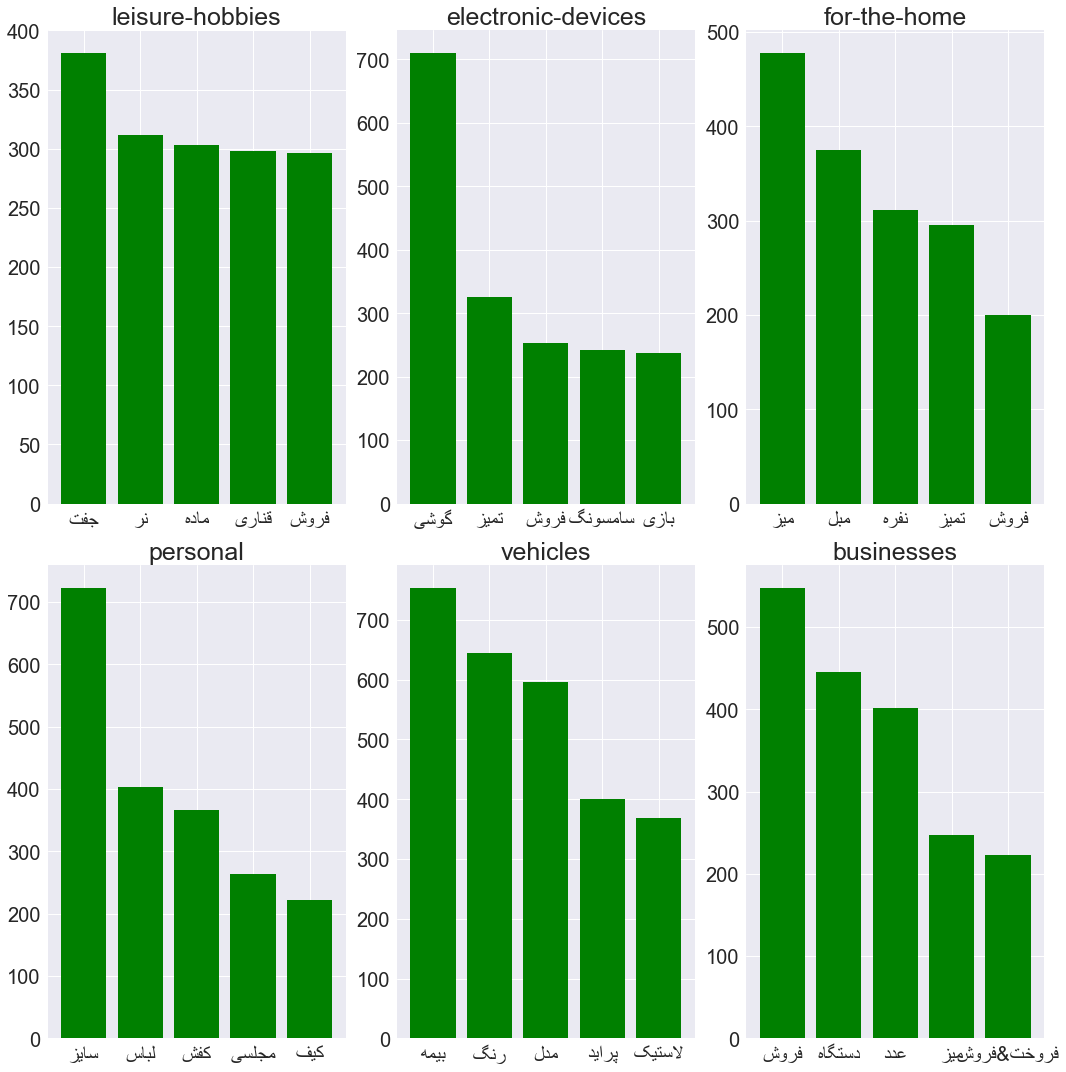

In [8]:
plt.style.use('seaborn')
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(15,15))
labels = train_data['categories'].unique()
for i in range(len(labels)):
    A = {k: v for k, v in sorted(list(naive_bayse.train_values[i].values())[0].items(), 
                             key=lambda item: item[1], reverse=True)}
    dictionary = dict(collections.Counter(A).most_common(5))
    for key in list(dictionary.keys()):
        dictionary[get_display(reshape(key))] = dictionary[key]
        del dictionary[key]
    axs[i%2][i%3].bar(dictionary.keys(), dictionary.values(), color='g')
    axs[i%2][i%3].set_title(labels[i], fontsize=25)
    for label in (axs[i%2][i%3].get_xticklabels() + axs[i%2][i%3].get_yticklabels()):
        label.set_fontsize(20)


***
# Phase three: Evaluation
## To evaluate the model, we use the following 4 criteria:<br>
#### **1- Accuracy**: Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. $$Accuracy = \frac{\text{Correct Detected}}{Total}$$
#### **2- Precision**: Precision is the ratio of correctly predicted class observations to the total predicted class observations. $$Precision = \frac{\text{Correct Detected Class}}{All Detected Class}$$
#### **3- Recall**: Recall is the ratio of correctly predicted class observations to the all observations in actual class. $$Recall = \frac{\text{Correct Detected Class}}{Total Class}$$
#### **4- F1**: F1 Score is the weighted average of Precision and Recall. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution.<br><br>$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$<br>
#### See this [link](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) for more information.<br>
***
### Q7) Why Precision or Recall value each is not enough to describe the performance of a classifier?
#### A classifier with **high precision** gives very few incorrect answers. We could imagine a classifier which achieves this by being very conservative, that is, it would avoid returning documents that it is not completely certain about and therefore fails to return many relevant documents.<br> A classifier with **high recall** misses very few correct answers. We could imagine a classifier which achieves this by being very permissive, that is, it would return documents that it is not completely certain about and therefore also return many irrelevant documents.<br> For example, if we have a very conservative model, it doesn't predict a lot. So its precision value will increase, whereas its recall value will decrease and vice versa. Here for the case that we don't use additive smoothing, the precision value is high because we don't predict much.
***
### Q8) What type of averaging F1 use? And why does it matter?
#### F1 uses the **harmonic mean**. Similar to arithmetic mean, the F1-score will always be somewhere in between precision and recall. But it behaves differently: the F1-score gives a larger weight to lower numbers.<br> Harmonic mean matters in F1, because it is never higher than the geometrical mean. It also tends towards the least number, minimizing the impact of the large outliers and maximizing the impact of small ones. The F-measure, therefore, tends to privilege balanced systems.
***
### Q9) What is macro, micro, and weighted averaging?
#### In **macro averaged** is computed as a simple arithmetic mean. For example in macro-F1, we compute arithmetic mean of our per-class F1-scores.
#### In **weighted averaged**, we have different weights for each item. For example in weighted-F1, we weight the F1-score of each class by the number of samples from that class. 
#### In **micro averaged**, we look at all samples together. So here micro-F1, micro-precision, micro-recall, and accuracy are equal. 

In [9]:
class Evaluation:
    def __init__(self, predicted, actual_value):
        self.predicted = predicted
        self.actual_value = actual_value
        
    def correct_detected(self):
        return np.sum(self.predicted == self.actual_value)
    
    def total(self):
        return len(self.actual_value)
    
    def correct_detected_class(self, category):
        cnt = 0
        for i, j in zip(self.actual_value, self.predicted):
            if j == category:
                if i == j:
                    cnt += 1
        return cnt
        
    def all_detected_class(self, category):
        return collections.Counter(self.predicted)[category]
    
    def total_class(self, category):
        return collections.Counter(self.actual_value)[category]
    
    def calc_accuracy(self):
        return self.correct_detected() / self.total()
    
    def calc_precision(self, category):
        return self.correct_detected_class(category) / self.all_detected_class(category)
        
    def calc_recall(self, category):
        return self.correct_detected_class(category) / self.total_class(category)
    
    def calc_F1(self, category):
        return 2 * (self.calc_precision(category) * self.calc_recall(category)) \
               / (self.calc_precision(category) + self.calc_recall(category))
    
    def calc_macro_F1(self, F1s):
        return sum(F1s) / len(F1s)
    
    def calc_weighted_F1(self, F1s, weights):
        s = 0
        for F1, weight in zip(F1s, weights):
            s += weight * F1
        return s / sum(weights)
    
    def calc_micro_F1(self):
        return self.calc_accuracy()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(test_data['categories'], predicted, target_names=labels))
print(classification_report(test_data['categories'], add_smooth_predicted, target_names=labels))

                    precision    recall  f1-score   support

   leisure-hobbies       0.71      0.27      0.40       300
          vehicles       0.91      0.21      0.34       300
      for-the-home       0.84      0.38      0.52       300
          personal       0.23      0.98      0.37       300
electronic-devices       0.92      0.35      0.50       300
        businesses       0.97      0.32      0.48       300

          accuracy                           0.42      1800
         macro avg       0.76      0.42      0.44      1800
      weighted avg       0.76      0.42      0.44      1800

                    precision    recall  f1-score   support

   leisure-hobbies       0.77      0.78      0.78       300
          vehicles       0.92      0.92      0.92       300
      for-the-home       0.79      0.89      0.84       300
          personal       0.92      0.82      0.87       300
electronic-devices       0.87      0.89      0.88       300
        businesses       0.94      0

***
# Results
## - Using Additive Smoothing

In [11]:
evaluation_additive = Evaluation(add_smooth_predicted, test_data['categories'])
cols = ['Businesses', 'Electronic Devices', 'For the home', 
        'Leisure Hobbies', 'Personal', 'Vehicles', 'All Classes']

labels = ['businesses', 'electronic-devices', 'for-the-home', 
          'leisure-hobbies', 'personal', 'vehicles']

recalls, precisions, F1s, accuracies, macro_avgs, \
    micro_avgs, weighted_avgs = [], [], [], [], [], [], []

for label in labels:
    recalls.append(evaluation_additive.calc_recall(label))
    precisions.append(evaluation_additive.calc_precision(label))
    F1s.append(evaluation_additive.calc_F1(label))
    
recalls.append('-')
F1s.append('-')
precisions.append('-')
for i in range(len(labels)):
    accuracies.append('-'), macro_avgs.append('-'), \
    micro_avgs.append('-'), weighted_avgs.append('-')
    
accuracies.append(evaluation_additive.calc_accuracy())
macro_avgs.append(evaluation_additive.calc_macro_F1(F1s[:len(labels)]))
micro_avgs.append(evaluation_additive.calc_micro_F1())
weights = [1]*len(labels)
weighted_avgs.append(evaluation_additive.calc_weighted_F1(F1s[:len(labels)], weights))
df = pd.DataFrame([precisions, recalls, F1s, accuracies,
              macro_avgs, micro_avgs, weighted_avgs], columns=cols, 
             index=['Precision', 'Recall', 'F1-score', 'Accuracy', 
                    'Macro Avg', 'Micro Avg', 'Weighted Avg'])

display(df)

,Businesses,Electronic Devices,For the home,Leisure Hobbies,Personal,Vehicles,All Classes
Precision,0.772277,0.919732,0.789941,0.924812,0.867314,0.940351,-
Recall,0.78,0.916667,0.89,0.82,0.893333,0.893333,-
F1-score,0.776119,0.918197,0.836991,0.869258,0.880131,0.916239,-
Accuracy,-,-,-,-,-,-,0.865556
Macro Avg,-,-,-,-,-,-,0.866156
Micro Avg,-,-,-,-,-,-,0.865556
Weighted Avg,-,-,-,-,-,-,0.866156


***
## - Without Using Additive Smoothing

In [12]:
evaluation = Evaluation(predicted, test_data['categories'])
cols = ['Businesses', 'Electronic Devices', 'For the home', 
        'Leisure Hobbies', 'Personal', 'Vehicles', 'All Classes']

labels = ['businesses', 'electronic-devices', 'for-the-home', 
          'leisure-hobbies', 'personal', 'vehicles']

recalls, precisions, F1s, accuracies, macro_avgs, \
    micro_avgs, weighted_avgs = [], [], [], [], [], [], []

for label in labels:
    recalls.append(evaluation.calc_recall(label))
    precisions.append(evaluation.calc_precision(label))
    F1s.append(evaluation.calc_F1(label))
    
recalls.append('-')
F1s.append('-')
precisions.append('-')
for i in range(len(labels)):
    accuracies.append('-'), macro_avgs.append('-'), \
    micro_avgs.append('-'), weighted_avgs.append('-')
    
accuracies.append(evaluation.calc_accuracy())
macro_avgs.append(evaluation.calc_macro_F1(F1s[:len(labels)]))
micro_avgs.append(evaluation.calc_micro_F1())
weights = [1]*len(labels)
weighted_avgs.append(evaluation.calc_weighted_F1(F1s[:len(labels)], weights))

df = pd.DataFrame([precisions, recalls, F1s, accuracies,
              macro_avgs, micro_avgs, weighted_avgs], columns=cols, 
             index=['Precision', 'Recall', 'F1-score', 'Accuracy', 
                    'Macro Avg', 'Micro Avg', 'Weighted Avg'])

display(df)

,Businesses,Electronic Devices,For the home,Leisure Hobbies,Personal,Vehicles,All Classes
Precision,0.713043,0.911765,0.844444,0.230527,0.920354,0.969388,-
Recall,0.273333,0.206667,0.38,0.976667,0.346667,0.316667,-
F1-score,0.395181,0.336957,0.524138,0.373011,0.503632,0.477387,-
Accuracy,-,-,-,-,-,-,0.416667
Macro Avg,-,-,-,-,-,-,0.435051
Micro Avg,-,-,-,-,-,-,0.416667
Weighted Avg,-,-,-,-,-,-,0.435051


***
## Analyzing the results
#### The obvious thing we can see is that we have a big difference between using and not using the additive smoothing method.<br> Also, we can see that with using additive smoothing, the difference between **precision** and **recall** is not big, but without using additive smoothing, the difference between these two criteria is big.<br> The next thing is that the value of accuracy is close to the value of the F1-score, which means that accuracy is a good metric in deciding whether a model is good or not.

***
## Observing five wrong classified items
#### In Naive Bayes, if there are significant differences in the attribute distributions compared to the training dataset, the results won't be reliable. <br>In this problem, having more data is expected to result in better results.

In [13]:
i = 0
mistakes = []
for pred, actual_index in zip(add_smooth_predicted, range(len(test_data['categories']))):
    if i > 4:
        break
    if pred != test_data['categories'][actual_index]:
        i += 1
        mistakes.append(actual_index)

for mis in mistakes:
    print(test_data['title+description'].iloc[mis])
    print("Predicted category : ", add_smooth_predicted[mis])
    print("Actual category : ", test_data['categories'].iloc[mis])

مودم سلام مودم وسایل دیگه ب کشت&کار نمیاد مارکzyxel خرید شماره ی تماس گرفت&گیر NUM
Predicted category :  leisure-hobbies
Actual category :  electronic-devices
سیپوراکس سیپوراکس میکرو مک جی بی‌ال سرامیک سرا کاهنده نیترات نی اکواریوم درجه 1
Predicted category :  for-the-home
Actual category :  leisure-hobbies
موتور تزیینی جنس اهن کار دست عرضه صورت عمده تکی
Predicted category :  businesses
Actual category :  for-the-home
اسکیت حرفه‌ای رولربلید درحدنو اسکیت RollerBlade 80 mm Bio Dynamic سایز 41 43 درحد نو
Predicted category :  personal
Actual category :  leisure-hobbies
اچارشلاقی HEYCOالمان اصل الم سایز y0m5d1 مقاوم
Predicted category :  personal
Actual category :  businesses


#### We can see that some words that are common in categories, will lead naive bayse to fail. So looking in the words based on their context will be better in deciding each word is relates to what category.